In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import numpy as np

# 1. Veri yükleme
df = pd.read_csv("/Users/berkebilgin/Desktop/VSCODE/Python/470/dataset_clean.csv") #path ayarlayınız

print(df.shape)
df.head()


(71493, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,20001,3nqQXoyQOWXiESFLlDF1hG,Sam Smith;Kim Petras,Unholy (feat. Kim Petras),Unholy (feat. Kim Petras),100,156943,False,0.714,0.472,...,-7.375,1,0.0864,0.01300,0.000005,0.2660,0.238,131.121,4,dance
1,51664,2tTmW7RDtMQtBk7m2rYeSw,Bizarrap;Quevedo,"Quevedo: Bzrp Music Sessions, Vol. 52","Quevedo: Bzrp Music Sessions, Vol. 52",99,198937,False,0.621,0.782,...,-5.548,1,0.0440,0.01250,0.033000,0.2300,0.550,128.033,4,hip-hop
2,81210,4uUG5RXrOk84mYEfFvj3cK,David Guetta;Bebe Rexha,I'm Good (Blue),I'm Good (Blue),98,175238,True,0.561,0.965,...,-3.673,0,0.0343,0.00383,0.000007,0.3710,0.304,128.040,4,pop
3,89411,5ww2BF9slyYgNOk37BlC4u,Manuel Turizo,La Bachata,La Bachata,98,162637,False,0.835,0.679,...,-5.329,0,0.0364,0.58300,0.000002,0.2180,0.850,124.980,4,reggaeton
4,68305,6Sq7ltF9Qa7SNFBsV5Cogx,Bad Bunny;Chencho Corleone,Un Verano Sin Ti,Me Porto Bonito,97,178567,True,0.911,0.712,...,-5.105,0,0.0817,0.09010,0.000027,0.0933,0.425,92.005,4,latino


In [2]:
# 2. Hedef ve özellikler

target_col = "popularity"

# Modelde kullanmayı planladığımız numeric kolonlar:
numeric_features = [
    "duration_ms",
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "time_signature",
]

# Kategorik özellik
categorical_features = ["track_genre"]

# X, y oluştur
X = df[numeric_features + categorical_features]
y = df[target_col]


In [3]:
# Önce train + temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Sonra temp'i val + test'e bölündü (%15 / %15 olacak şekilde)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (50045, 14)
Val: (10724, 14)
Test: (10724, 14)


In [4]:
# Numeric ve kategorik kolonlar için transformer
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [5]:
# Baseline: popularity'nin ortalamasını tahmin eden model
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train[numeric_features], y_train)  # Baseline için sade numeric kullanıyoruz

y_val_pred_dummy = dummy.predict(X_val[numeric_features])

rmse_dummy = mean_squared_error(y_val, y_val_pred_dummy, squared=False)
mae_dummy = mean_absolute_error(y_val, y_val_pred_dummy)
r2_dummy = r2_score(y_val, y_val_pred_dummy)

print("=== Dummy Baseline (Mean) ===")
print("RMSE:", rmse_dummy)
print("MAE:", mae_dummy)
print("R^2:", r2_dummy)


=== Dummy Baseline (Mean) ===
RMSE: 18.77764128274384
MAE: 15.537042148824728
R^2: -2.424956899726993e-07


In [6]:
# Pipeline: preprocessing + Linear Regression
linreg_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", LinearRegression())
    ]
)

linreg_model.fit(X_train, y_train)

# Validation performansı
y_val_pred = linreg_model.predict(X_val)

rmse_lr = mean_squared_error(y_val, y_val_pred, squared=False)
mae_lr = mean_absolute_error(y_val, y_val_pred)
r2_lr = r2_score(y_val, y_val_pred)

print("=== Linear Regression + Pipeline ===")
print("RMSE:", rmse_lr)
print("MAE:", mae_lr)
print("R^2:", r2_lr)

print("\nKarşılaştırma (Val seti):")
print(f"Dummy RMSE: {rmse_dummy:.3f}  |  LR RMSE: {rmse_lr:.3f}")


=== Linear Regression + Pipeline ===
RMSE: 13.863393806430597
MAE: 9.901385794775058
R^2: 0.45492388872813105

Karşılaştırma (Val seti):
Dummy RMSE: 18.778  |  LR RMSE: 13.863


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# RF pipeline: preprocessing + RandomForest
rf_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),  # aynı preprocessor: num + cat
        ("regressor", RandomForestRegressor(
            random_state=42,
            n_jobs=-1
        ))
    ]
)

# Küçük bir hyperparametre grid
param_grid_rf = {
    "regressor__n_estimators": [100, 200],
    "regressor__max_depth": [None, 10, 20],
    "regressor__min_samples_split": [2, 5],
    "regressor__min_samples_leaf": [1, 2],
}

rf_search = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid_rf,
    cv=3,              # 3-fold cross validation
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=2
)

rf_search.fit(X_train, y_train)

print("En iyi RF parametreleri:", rf_search.best_params_)
print("RF CV (best) RMSE:", -rf_search.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=5, regressor__n_estimators=100; total time= 4.0min
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=5, regressor__n_estimators=100; total time= 4.0min
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=5, regressor__n_estimators=100; total time= 4.0min
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100; total time= 5.9min
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100; total time= 5.9min
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100; total time= 5.9min
[CV] END regressor__max_depth=None, regressor__min_sample

In [8]:
# GridSearch sonrası en iyi model çekildi
best_rf = rf_search.best_estimator_

# Validation set üzerinde tahmin
y_val_pred_rf = best_rf.predict(X_val)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_regression(y_true, y_pred, name="Model"):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"=== {name} ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R^2 : {r2:.4f}")
    print()
    
    return {"name": name, "rmse": rmse, "mae": mae, "r2": r2}

rf_metrics = evaluate_regression(y_val, y_val_pred_rf, name="Random Forest (Val)")

rf_metrics



=== Random Forest (Val) ===
RMSE: 13.5954
MAE : 9.5404
R^2 : 0.4758



{'name': 'Random Forest (Val)',
 'rmse': 13.595394601466477,
 'mae': 9.540433531280632,
 'r2': 0.4757943911891791}

In [9]:
# Train + Val birleştirildi
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

# Best params'tan RF'i yeniden kuruldu
final_rf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", RandomForestRegressor(
            random_state=42,
            n_jobs=-1,
            max_depth=None,
            min_samples_leaf=2,
            min_samples_split=5,
            n_estimators=200
        ))
    ]
)

final_rf.fit(X_train_full, y_train_full)

# Test performansı
y_test_pred = final_rf.predict(X_test)
final_test_metrics = evaluate_regression(y_test, y_test_pred, name="FINAL RF on TEST")
final_test_metrics


=== FINAL RF on TEST ===
RMSE: 13.0358
MAE : 9.1288
R^2 : 0.4978



{'name': 'FINAL RF on TEST',
 'rmse': 13.03583340424146,
 'mae': 9.128782809844054,
 'r2': 0.4978292601212573}

In [10]:
import xgboost
from xgboost import XGBRegressor

# XGBoost pipeline: preprocessing + XGBRegressor
xgb_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", XGBRegressor(
            objective="reg:squarederror",
            random_state=42,
            n_estimators=300,        
            learning_rate=0.1,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            n_jobs=-1,
            tree_method="hist"       # genelde hızlı
        ))
    ]
)

# Eğitim
xgb_pipe.fit(X_train, y_train)

# Val üzerinde tahmin
y_val_pred_xgb = xgb_pipe.predict(X_val)

# Metrikler
xgb_metrics = evaluate_regression(y_val, y_val_pred_xgb, name="XGBoost (Val)")
xgb_metrics


=== XGBoost (Val) ===
RMSE: 13.4860
MAE : 9.5550
R^2 : 0.4842



{'name': 'XGBoost (Val)',
 'rmse': 13.485960000603061,
 'mae': 9.554994765543704,
 'r2': 0.4841994947891266}

In [11]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# XGBoost pipeline
xgb_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", XGBRegressor(
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1,
            tree_method="hist"
        ))
    ]
)

param_grid_xgb = {
    "regressor__n_estimators": [200, 400],
    "regressor__learning_rate": [0.05, 0.1],
    "regressor__max_depth": [3, 6],
    "regressor__subsample": [0.8, 1.0],
    "regressor__colsample_bytree": [0.8, 1.0],
    "regressor__reg_alpha": [0.0, 0.1],
    "regressor__reg_lambda": [1.0, 2.0],
}

xgb_search = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid_xgb,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=2
)

xgb_search.fit(X_train, y_train)

print("En iyi XGB parametreleri:", xgb_search.best_params_)
print("XGB CV (best) RMSE:", -xgb_search.best_score_)

best_xgb = xgb_search.best_estimator_
y_val_pred_xgb = best_xgb.predict(X_val)
xgb_metrics = evaluate_regression(y_val, y_val_pred_xgb, name="XGBoost (Val, tuned)")
xgb_metrics

Fitting 3 folds for each of 128 candidates, totalling 384 fits
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=200, regressor__reg_alpha=0.0, regressor__reg_lambda=1.0, regressor__subsample=0.8; total time=   0.5s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=200, regressor__reg_alpha=0.0, regressor__reg_lambda=1.0, regressor__subsample=0.8; total time=   0.5s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=200, regressor__reg_alpha=0.0, regressor__reg_lambda=1.0, regressor__subsample=1.0; total time=   0.5s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=200, regressor__reg_alpha=0.0, regressor__reg_lambda=1.0, regressor__subsample=1.0; total time=   0.5s
[CV] END regressor__colsample_bytree=0.8,

{'name': 'XGBoost (Val, tuned)',
 'rmse': 13.417286478357637,
 'mae': 9.390619864343419,
 'r2': 0.4894392625937001}

In [12]:
results = []

# Dummy
y_val_pred_dummy = dummy.predict(X_val[numeric_features])
dummy_metrics = evaluate_regression(y_val, y_val_pred_dummy, name="Dummy (Mean)")
results.append(dummy_metrics)

# Linear Regression
y_val_pred_lr = linreg_model.predict(X_val)
lr_metrics = evaluate_regression(y_val, y_val_pred_lr, name="Linear Regression")
results.append(lr_metrics)

# Random Forest
y_val_pred_rf = best_rf.predict(X_val)
rf_metrics = evaluate_regression(y_val, y_val_pred_rf, name="Random Forest (Val)")
results.append(rf_metrics)

# XGBoost
results.append(xgb_metrics)

import pandas as pd
results_df = pd.DataFrame(results)
results_df.sort_values(by="rmse")


=== Dummy (Mean) ===
RMSE: 18.7776
MAE : 15.5370
R^2 : -0.0000

=== Linear Regression ===
RMSE: 13.8634
MAE : 9.9014
R^2 : 0.4549

=== Random Forest (Val) ===
RMSE: 13.5954
MAE : 9.5404
R^2 : 0.4758



,name,rmse,mae,r2
3,"XGBoost (Val, tuned)",13.417286,9.390620,4.894393e-01
2,Random Forest (Val),13.595395,9.540434,4.757944e-01
1,Linear Regression,13.863394,9.901386,4.549239e-01
0,Dummy (Mean),18.777641,15.537042,-2.424957e-07


In [13]:
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)


In [14]:
# ========= TEST evaluation for ALL models (trained on Train+Val) =========
# This block is for reporting only

# Safety checks (helps avoid NameError if you didn't run previous cells)
required_vars = ["X_train_full","y_train_full","X_test","y_test","numeric_features","preprocessor",
                 "evaluate_regression","best_rf","best_xgb"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(f"Missing variables before running this cell: {missing}. Run previous cells (split, preprocess, RF/XGB tuning) first.")

test_results = []

# 1) Dummy (Mean) - fit on Train+Val
dummy_full = DummyRegressor(strategy="mean")
dummy_full.fit(X_train_full[numeric_features], y_train_full)
y_test_pred_dummy = dummy_full.predict(X_test[numeric_features])
test_results.append(evaluate_regression(y_test, y_test_pred_dummy, name="Dummy (Mean) - TEST"))

# 2) Linear Regression - retrain on Train+Val
linreg_full = Pipeline([
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])
linreg_full.fit(X_train_full, y_train_full)
y_test_pred_lr = linreg_full.predict(X_test)
test_results.append(evaluate_regression(y_test, y_test_pred_lr, name="Linear Regression - TEST"))

# 3) Random Forest - retrain on Train+Val using best estimator params
rf_params = best_rf.named_steps["regressor"].get_params()
rf_full = Pipeline([
    ("preprocess", preprocessor),
    ("regressor", RandomForestRegressor(**rf_params))
])
rf_full.fit(X_train_full, y_train_full)
y_test_pred_rf = rf_full.predict(X_test)
test_results.append(evaluate_regression(y_test, y_test_pred_rf, name="Random Forest (tuned) - TEST"))

# 4) XGBoost - retrain on Train+Val using best estimator params
xgb_params = best_xgb.named_steps["regressor"].get_params()
xgb_full = Pipeline([
    ("preprocess", preprocessor),
    ("regressor", XGBRegressor(**xgb_params))
])
xgb_full.fit(X_train_full, y_train_full)
y_test_pred_xgb = xgb_full.predict(X_test)
test_results.append(evaluate_regression(y_test, y_test_pred_xgb, name="XGBoost (tuned) - TEST"))

test_results_df = pd.DataFrame(test_results).sort_values(by="rmse")
test_results_df


=== Dummy (Mean) - TEST ===
RMSE: 18.3956
MAE : 15.2346
R^2 : -0.0000

=== Linear Regression - TEST ===
RMSE: 13.4970
MAE : 9.6357
R^2 : 0.4617

=== Random Forest (tuned) - TEST ===
RMSE: 13.0358
MAE : 9.1288
R^2 : 0.4978

=== XGBoost (tuned) - TEST ===
RMSE: 12.9749
MAE : 9.0674
R^2 : 0.5025



,name,rmse,mae,r2
3,XGBoost (tuned) - TEST,12.974869,9.067406,0.502515
2,Random Forest (tuned) - TEST,13.035833,9.128783,0.497829
1,Linear Regression - TEST,13.496958,9.635748,0.461674
0,Dummy (Mean) - TEST,18.395600,15.234610,-0.000004


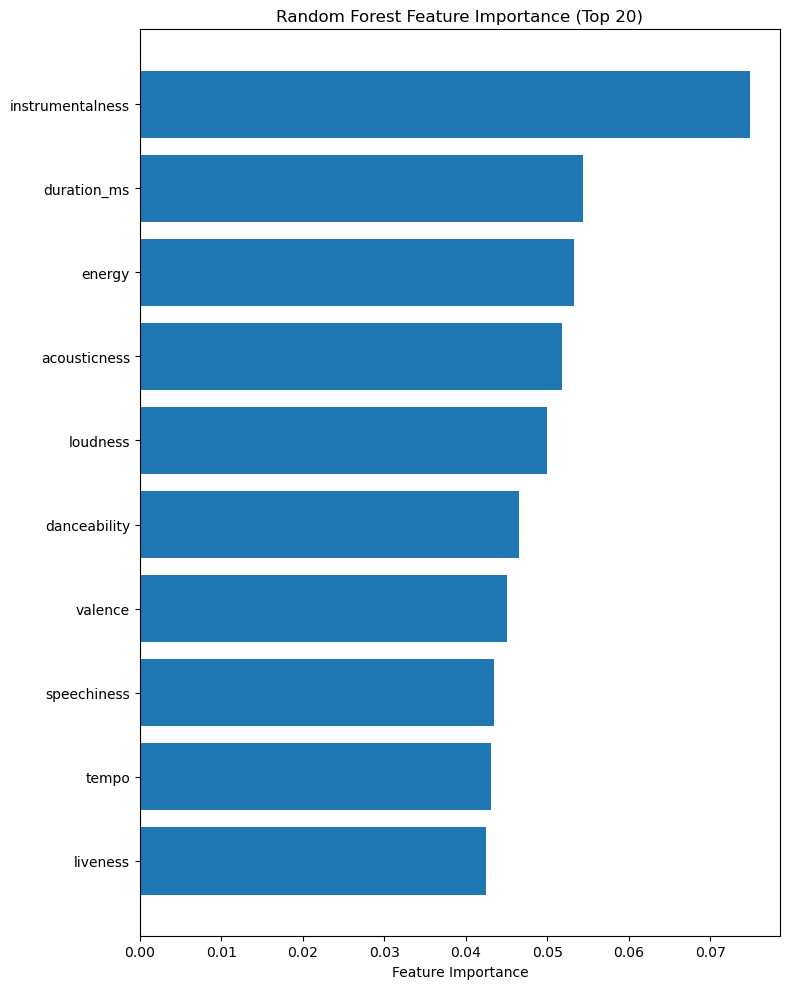

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Pipeline içindeki parçaları çek
preprocess = final_rf.named_steps["preprocess"]
rf_model = final_rf.named_steps["regressor"]

# Numeric feature isimleri zaten elimizde
num_features = numeric_features

# Kategorik feature’lar için OneHotEncoder’dan isimler
cat_encoder = preprocess.named_transformers_["cat"]
cat_features = list(cat_encoder.get_feature_names_out(categorical_features))

# Son feature listesi (preprocess sonrası)
feature_names = num_features + cat_features

# Importance değerleri
importances = rf_model.feature_importances_
importances = np.array(importances)

# En önemli 10 feature’ı seç
top_k = 10
idx = np.argsort(importances)[-top_k:]   # en büyük 10
top_importances = importances[idx]
top_names = np.array(feature_names)[idx]

# Daha okunur olsun diye sıralamayı tekrar düzelt (küçükten büyüğe)
order = np.argsort(top_importances)
top_importances = top_importances[order]
top_names = top_names[order]

plt.figure(figsize=(8, 10))
plt.barh(top_names, top_importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance (Top 20)")
plt.tight_layout()
plt.show()


In [16]:
# Test tahminleri (final_RF zaten Train+Val'da eğitilmişti)
y_test_pred = final_rf.predict(X_test)


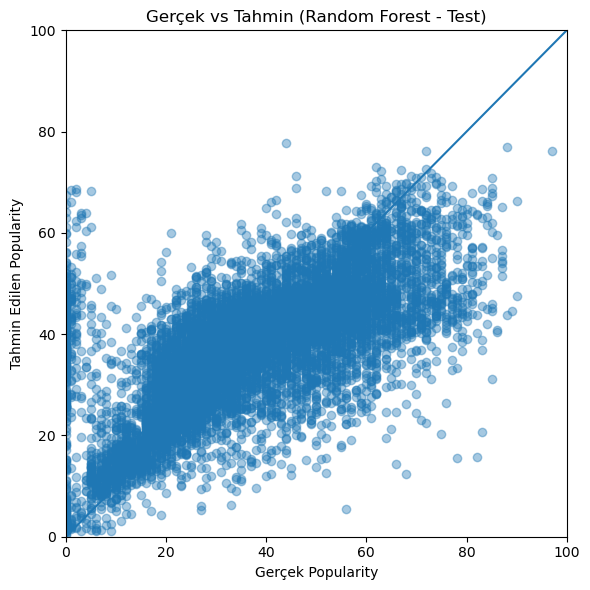

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.4)
plt.plot([0, 100], [0, 100])  # y = x referans çizgisi
plt.xlabel("Gerçek Popularity")
plt.ylabel("Tahmin Edilen Popularity")
plt.title("Gerçek vs Tahmin (Random Forest - Test)")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


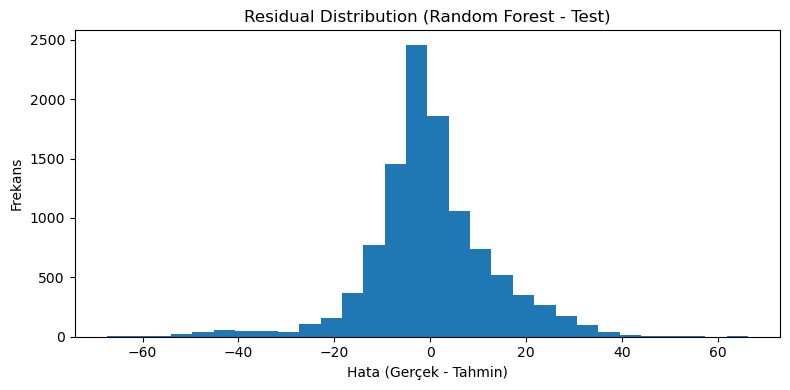

In [18]:
residuals = y_test - y_test_pred

plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=30)
plt.xlabel("Hata (Gerçek - Tahmin)")
plt.ylabel("Frekans")
plt.title("Residual Distribution (Random Forest - Test)")
plt.tight_layout()
plt.show()


In [19]:
test_df_eval = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_test_pred
})
test_df_eval["bin"] = pd.cut(
    test_df_eval["y_true"],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["0-20", "20-40", "40-60", "60-80", "80-100"]
)

group_stats = test_df_eval.groupby("bin").apply(
    lambda g: pd.Series({
        "RMSE": np.sqrt(np.mean((g["y_true"] - g["y_pred"])**2)),
        "MAE": np.mean(np.abs(g["y_true"] - g["y_pred"])),
        "count": len(g)
    })
)

group_stats


/var/folders/hs/j2t0cb3j02n7jvt7qnfzv4lc0000gn/T/ipykernel_17323/65771600.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = test_df_eval.groupby("bin").apply(
/var/folders/hs/j2t0cb3j02n7jvt7qnfzv4lc0000gn/T/ipykernel_17323/65771600.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_stats = test_df_eval.groupby("bin").apply(


,RMSE,MAE,count
bin,,,
0-20,13.800881,8.978330,1855.0
20-40,8.492693,6.556163,4106.0
40-60,10.339437,7.688854,3355.0
60-80,20.457227,17.618196,1076.0
80-100,32.253312,30.348600,74.0
